In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
print("Classes found by automap:", Base.classes.keys())

Classes found by automap: ['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the dataset is: {recent_date}")

The most recent date in the dataset is: 2017-08-23


Date one year from the last date in dataset: 2016-08-23


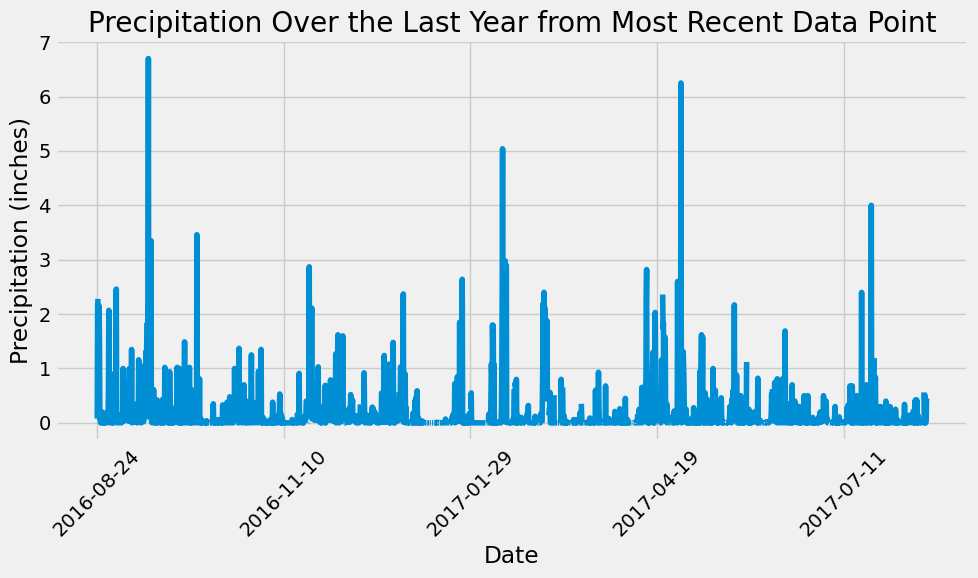

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set
one_year_ago = dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=365)
print(f"Date one year from the last date in dataset: {one_year_ago.date()}")

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df['Precipitation'].plot()
plt.title('Precipitation Over the Last Year from Most Recent Data Point')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [34]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = df['Precipitation'].describe()

print("Summary Statistics for Precipitation Data:")
display(precipitation_stats.to_frame())

Summary Statistics for Precipitation Data:


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [36]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("Stations and their observation counts in descending order:")
for station, count in station_counts:
    print(station, count)

# Which station has the greatest number of observations?
most_active_station = station_counts[0][0]
print(f"Station with the greatest number of observations: {most_active_station}")

Stations and their observation counts in descending order:
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511
Station with the greatest number of observations: USC00519281


In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]:.2f}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


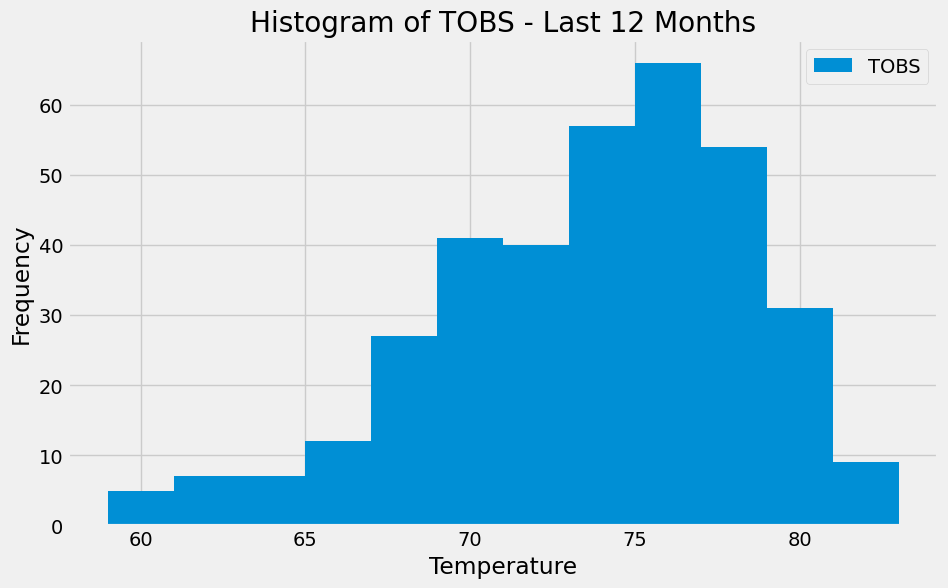

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station).scalar()
last_year_date = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Retrieve the last 12 months of TOBS data
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= last_year_date).\
    order_by(Measurement.date).all()

# Plotting the results as a histogram
df_tobs = pd.DataFrame(tobs_data, columns=['date', 'tobs'])
plt.figure(figsize=(10, 6))
plt.hist(df_tobs['tobs'], bins=12, label='TOBS')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of TOBS - Last 12 Months')
plt.legend()
plt.show()

# Close Session

In [39]:
# Close Session
session.close()